In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 18
})

The diffusion equation is expressed as
\begin{equation}
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2},
\end{equation}
where $u(x,t)$ is the solution and D the diffusion coefficient. This equation can be solved using discrete methods (FEM, FVD, FDM) or through other methods like stochastic (random walk)

The solution to the diffusion equation when the initial condition is a delta function is given by
\begin{equation}
u(x,t) = \frac{1}{2\sqrt{Dt}} e^{-\frac{x^2}{4Dt}}
\end{equation}
where the initial condition is
\begin{equation}
u(x=x_0,0) = \delta(x_0)
\end{equation}

Due to the linearlity of the PDE, the diffusion solution can be computed using green's function for any $f(x)$ initial condition. For simplicity, we have taken a gaussian function as initial condition 

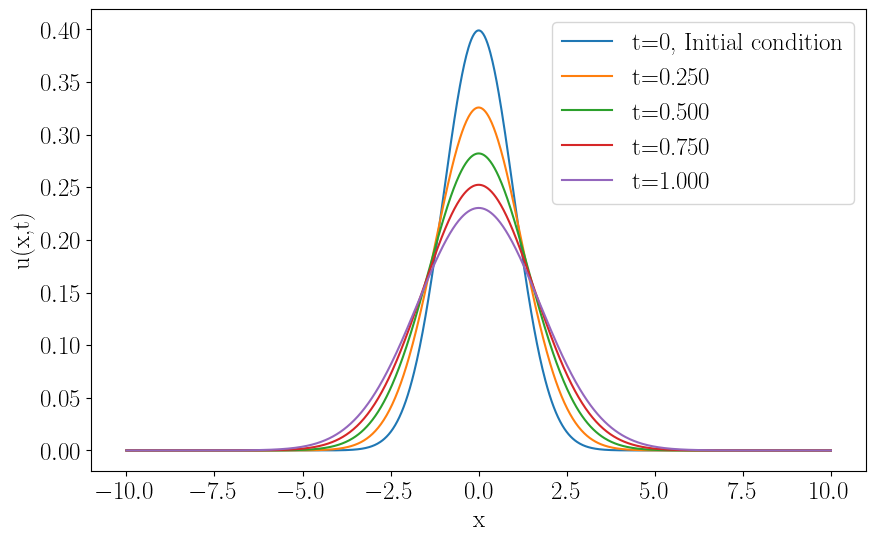

In [130]:
x = np.linspace(-10, 10, 1000)
x_domain = np.linspace(-50,50,5000)
D = 1
t = np.array([0,0.25,0.5,0.75,1])

def G(x, t, D):
    if t <= 0:
        return np.zeros_like(x)  
    return 1 / np.sqrt(4 * np.pi * D * t) * np.exp(-x**2 / (4 * D * t))

def f_0(x):
    sigma = 1
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2))

def solve_diffusion(x, t, D, f_initial, x_domain):
    dx = x_domain[1] - x_domain[0]
    solution = np.zeros_like(x)
    for i, x_i in enumerate(x):
        kernel = G(x_i - x_domain, t, D)
        integrand = kernel * f_initial(x_domain)
        solution[i] = np.trapz(y=integrand, x=x_domain)
    return solution

plt.figure(figsize=(10,6))
plt.plot(x, f_0(x),label=f't=0, Initial condition',alpha=1)
for ti in t[1:]:
    solution = solve_diffusion(x, ti, D, f_0, x_domain)
    plt.plot(x, solution,label=f't={ti:.3f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()


The idea behind PINNs is to define a neural network that in its loss it incorporates the PDE. The loss consists of several parts:

Residual loss - PDE constraint ($\mathcal{L}_{\text{PDE}}$), Boundary conditions ($\mathcal{L}_{\text{BC}}$), Initial conditions ($\mathcal{L}_{\text{IC}}$)

\begin{equation}
 \mathcal{L} = \mathcal{L}_{\text{PDE}} + \lambda_{\text{BC}}\mathcal{L}_{\text{BC}} + \lambda_{\text{IC}}\mathcal{L}_{\text{IC}},
\end{equation}

where $\lambda_{\text{BC}}$ and $\lambda_{\text{IC}}$ are hyperparameters to balance the contributions of the boundary and initial conditions to the total loss.

\begin{equation}
\mathcal{L}_{\text{PDE}} = \frac{1}{N} \sum_{i=1}^{N}{\frac{\partial u_i}{\partial t} - D \frac{\partial^2 u_i}{\partial x^2}}
\end{equation}

\begin{equation}
\mathcal{L}_{\text{BC}} = \frac{1}{N_b} \sum_{i=1}^{N_b}{u(x_b,t_b)-g(x_b,t_b)}
\end{equation}

\begin{equation}
\mathcal{L}_{\text{IC}} = \frac{1}{N} \sum_{i=1}^{N}{u(x_0,0)-h(x_0)}
\end{equation}

We will consider no flux boundary conditions so $\frac{\partial u}{\partial x} = 0$ at $x=10$ and at $x=-10$ and initial condition a delta function at $x=0$

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PINN_diffusion(nn.Module):
    def __init__(self, layers):
        super(PINN_diffusion, self).__init__()
        self.layers = []
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            setattr(self, f'linear_{i}', self.layers[-1])

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = torch.tanh(x)
        return x    

We will code the losses for the internal points of the PDE


In [132]:
def compute_loss_pde(u, input, D):
    #compute the partial derivatives of the solution with respect to time and space
    u_t = torch.autograd.grad(u, input, grad_outputs=torch.ones_like(u), create_graph=True)[0][:,1]
    u_x = torch.autograd.grad(u, input, grad_outputs=torch.ones_like(u), create_graph=True)[0][:,0]
    u_xx = torch.autograd.grad(u_x, input, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:,0]
    loss_pde = (u_t - D * u_xx)**2
    return loss_pde.mean()

Now, we will create a neural network and we will train it with just collocation points (Not within the initial condition or the boundary condition)

In [133]:
from tqdm import tqdm

neural_network = PINN_diffusion([2, 20, 20, 1])

internal_points = np.random.uniform(-10,10,1000)
time_points = np.random.uniform(0,1,1000)
points = np.stack((internal_points,time_points),axis=1)
print(points.shape)

points = torch.tensor(points, dtype=torch.float32,requires_grad=True)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print("Using device:", device)
loss_history = []

def train(nn, points, D, epoch, lr):
    optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
    nn.to(device)
    points = points.to(device)
    pbar = tqdm(range(epoch),desc="Training")
    for i in pbar:
        optimizer.zero_grad()
        u = nn(points)
        loss_pde = compute_loss_pde(u, points, D)
        loss_pde.backward()
        optimizer.step()
        loss_history.append(loss_pde.item())
        if i % 50 == 0:
            pbar.set_description(f"Epoch {i}, Loss: {loss_pde.item()}")
    return nn
    
D=1
trained_nn = train(neural_network, points, D, 1000, 0.001)

(1000, 2)
Using device: mps


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 950, Loss: 7.583930283772133e-08: 100%|██████████| 1000/1000 [00:08<00:00, 118.64it/s]


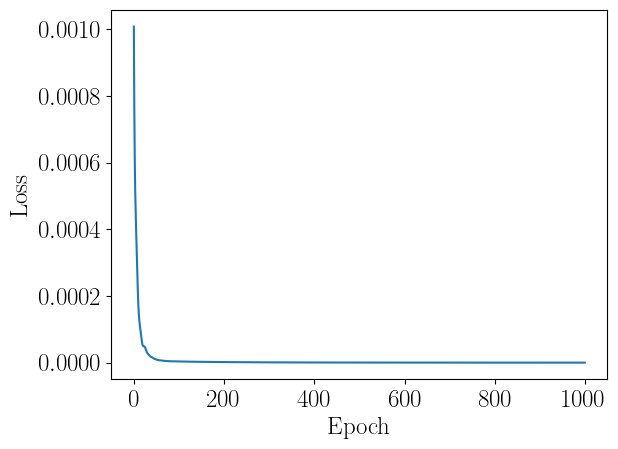

In [134]:
plt.plot(np.arange(len(loss_history)),loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [135]:
def obtain_solution(nn, x0, t):
    t = np.ones_like(x0)*t
    points = np.stack((x0,t),axis=1)    
    points = torch.tensor(points, dtype=torch.float32)
    nn.eval()
    with torch.no_grad():
        points = points.to(device)
        u_pred = nn(points)
        u_pred = u_pred.cpu().numpy()
    return u_pred[:,0], x0

Now, the PINNs has learned the interal nodes but doesn not know the initial condition or boundary condition. The PDE has infinite amount of solutions but the whole point is that they follow the PDE equation because we have enforced it in the loss. In the following code I compute the PDE using FD and check the residuals, they should be close to 0 

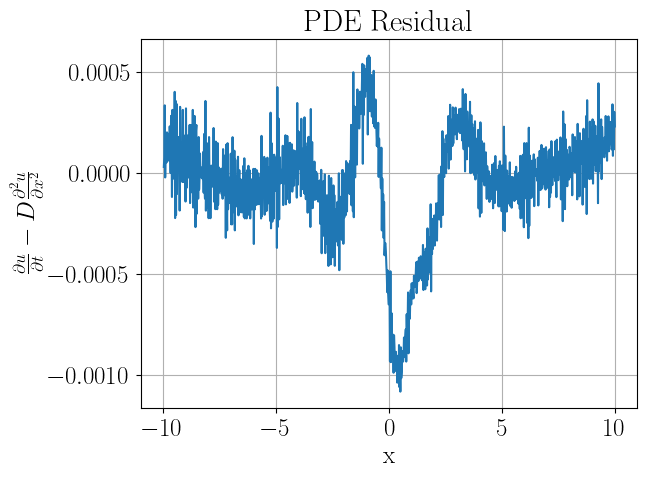

Residual mean: -4.9449092e-05
Residual max: 0.00058010273


In [136]:
x0 = np.linspace(-10,10,1000)

dt = 0.001
u_pred_only_internal, x_pred = obtain_solution(trained_nn, x0, 0.5)
u_pred_only_internal_dt, x_pred = obtain_solution(trained_nn, x0, 0.5+dt)

#dudt
du_dt = (u_pred_only_internal_dt - u_pred_only_internal) / dt
#d2udx2
dx = x0[1] - x0[0]
u = u_pred_only_internal.flatten()
d2u_dx2 = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2

D = 1  # diffusion coefficient
residual = du_dt[1:-1] - D * d2u_dx2

plt.plot(x_pred[1:-1],residual)
plt.xlabel('x')
plt.ylabel(r'$\frac{\partial u}{\partial t} - D\frac{\partial^2 u}{\partial x^2}$')
plt.title('PDE Residual')
plt.grid(True)
plt.show()

print("Residual mean:", np.mean(residual))
print("Residual max:", np.max(residual))

Now, we can fine-tune the neural network to solve the exact problem we want with the initial conditions. We are assuming an infinite domain so we do not consider boundary conditions

In [145]:
def compute_loss_pde(nn, points, D):
    u = nn(points)
    du = torch.autograd.grad(u.sum(), points, create_graph=True)[0]
    u_t, u_x = du[:, 1], du[:, 0]
    u_xx = torch.autograd.grad(u_x.sum(), points, create_graph=True)[0][:, 0]
    return ((u_t - D * u_xx)**2).mean()

def compute_loss_ic(nn, points, h):
    u = nn(points)
    loss_ic = (u-h)**2
    return loss_ic.mean()

def train(nn, points, h, epoch, lr):
    nn.train()
    optimizer = torch.optim.Adam(nn.parameters(), lr=lr)
    nn.to(device)
    points = points.to(device)
    h = h.to(device)
    pbar = tqdm(range(epoch),desc="Training")
    
    interior_points = points[points[:,1]>0]
    ic_points = points[points[:,1]==0]
    ic_values = h[points[:,1]==0]
    
    for i in pbar:
        optimizer.zero_grad()
        loss_pde = compute_loss_pde(nn, interior_points, 1.)
        loss_ic = compute_loss_ic(nn, ic_points, ic_values)
        loss = loss_pde + 5*loss_ic
        loss.backward(retain_graph=True)
        optimizer.step()
        if i % 50 == 0:
            pbar.set_description(f"Epoch {i}, Loss: {loss.item()}")
    return nn

h = f_0(all_points[:,0])
points = torch.tensor(all_points, dtype=torch.float32,requires_grad=True)
h = torch.tensor(h, dtype=torch.float32,requires_grad=True)
neural_network = PINN_diffusion([2, 10, 10, 1])
trained_nn_with_ic = train(neural_network, points, h, 5000, 0.08)



Epoch 4950, Loss: 0.06051791459321976: 100%|██████████| 5000/5000 [00:59<00:00, 84.53it/s] 


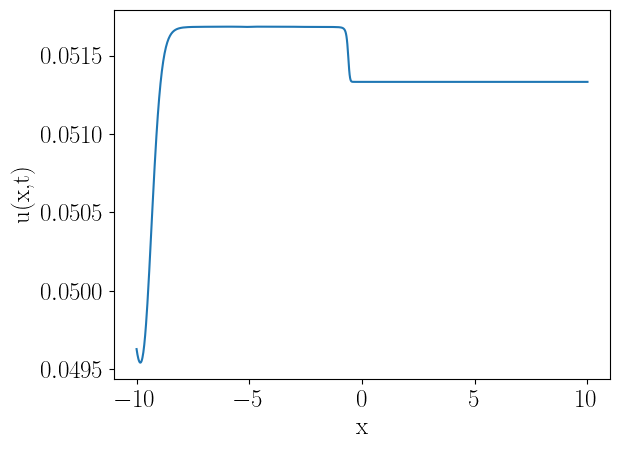

In [139]:
x0 = np.linspace(-10,10,1000)

u_pred_only_internal, x_pred = obtain_solution(trained_nn_with_ic, x0, 0.5)


plt.plot(x_pred,u_pred_only_internal)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim.rmsprop
from tqdm import tqdm
import matplotlib.pyplot as plt

def f_0(x):
    return 1.0
    sigma = 1
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2))

def get_points(N_ic, N_internal):
    
    x_ic= np.random.uniform(-10,10,N_ic)
    t_0 = np.zeros_like(x_ic)

    x_internal = np.random.uniform(-10,10,N_internal)
    t_internal = np.random.uniform(0,1,N_internal)

    internal_points = np.stack((x_internal,t_internal),axis=1)
    initial_points = np.stack((x_ic,t_0),axis=1)  
    all_points = np.concatenate((internal_points,initial_points),axis=0)    
    h = torch.tensor(f_0(all_points[:,0]), dtype=torch.float32)
    all_points = torch.tensor(all_points, dtype=torch.float32)
    
    return all_points, h

class PINN_diffusion(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = []
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.layers.append(nn.Tanh())
                self.layers.append(nn.BatchNorm1d(layers[i+1]))
        self.network = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.network(x)


def compute_loss_pde(nn, points, D):
    points.requires_grad_(True)
    u = nn(points)
    du = torch.autograd.grad(u.sum(), points, create_graph=True)[0]
    u_t, u_x = du[:, 1], du[:, 0]
    u_xx = torch.autograd.grad(u_x.sum(), points, create_graph=True)[0][:, 0]
    points.requires_grad_(False)
    return ((u_t - D * u_xx)**2).mean()

def compute_loss_ic(nn, points, h):
    points.requires_grad_(True)
    u = nn(points)
    points.requires_grad_(False)
    loss_ic = (u - h)**2
    return loss_ic.mean()

def train(nn, points, h, epochs, lr, device='cuda' if torch.cuda.is_available() else 'cpu'):
    nn.train()
    optimizer = torch.optim.RMSprop(nn.parameters(), lr=lr, alpha=0.9, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.008, step_size_up=500, mode='triangular2')
    nn.to(device)

    pbar = tqdm(range(epochs), desc="Training")
    loss_ic_history, loss_pde_history = [], []
    
    for i in pbar:
        
        points, h = get_points(300, 300)
        points = points.to(device)
        h = h.to(device)
        
        interior_points = points[points[:,1]>0].clone()
        ic_points = points[points[:,1]==0].clone()
        ic_values = h[points[:,1]==0].clone()
        
        optimizer.zero_grad()
        loss_pde = compute_loss_pde(nn, interior_points, D=1.0)
        loss_ic = compute_loss_ic(nn, ic_points, ic_values)
        loss = loss_pde + 10*loss_ic
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        loss_ic_history.append(loss_ic.item())
        loss_pde_history.append(loss_pde.item())
        if i % 50 == 0:
            pbar.set_description(f"Epoch {i}, Loss: {loss.item():.6f}")
    
    return nn, loss_ic_history, loss_pde_history

# Setup and training
device = 'mps' if torch.mps.is_available() else 'cpu'
neural_network = PINN_diffusion([2, 64, 64, 32, 16, 1])

trained_nn, training_losses_ic, training_losses_pde = train(neural_network, points, h, epochs=5000, lr=0.001)

plt.plot(training_losses_ic,label='IC loss')
plt.plot(training_losses_pde,label='PDE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Training:   0%|          | 0/5000 [00:00<?, ?it/s]


IndexError: too many indices for tensor of dimension 0